In [1]:
import pandas as pd
from location import normalize_location
import matplotlib.pyplot as plt

In [2]:
flatiron_users = pd.read_pickle('scraped_data/userinfo.pkl')
forks = pd.read_pickle('scraped_data/flatiron.pkl')

In [3]:
flatiron_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481 entries, 0 to 3480
Data columns (total 11 columns):
_id             3481 non-null object
company         173 non-null object
created_at      3481 non-null datetime64[ns, UTC]
email           234 non-null object
followers       3481 non-null int64
following       3481 non-null int64
location        582 non-null object
login           3481 non-null object
name            967 non-null object
public_repos    3481 non-null int64
is_user         3481 non-null bool
dtypes: bool(1), datetime64[ns, UTC](1), int64(3), object(6)
memory usage: 275.4+ KB


In [4]:
flatiron_users['location'] = flatiron_users['location'].apply(normalize_location)
flatiron_users['location'].value_counts()

new york                                                                             181
dc                                                                                    28
london                                                                                21
seattle                                                                               19
houston                                                                               13
san francisco                                                                         13
los angeles                                                                           12
denver                                                                                 8
chicago                                                                                7
boston                                                                                 7
atlanta                                                                                7
united states        

In [5]:
flatiron_users.head()

,_id,company,created_at,email,followers,following,location,login,name,public_repos,is_user
0,5cbb46bee67ba1f40e709f78,None,2019-03-31 17:16:31+00:00,None,0,0,None,williamjfermo,None,6,True
1,5cbb46bfe67ba1f40e709f79,None,2017-07-07 01:20:47+00:00,None,0,0,None,Erica-Brown,None,7,True
2,5cbb46c0e67ba1f40e709f7a,None,2019-04-19 18:11:25+00:00,None,0,0,None,SaidaZardi,None,7,True
3,5cbb46c1e67ba1f40e709f7b,None,2014-09-24 01:07:36+00:00,None,0,0,None,laueternal,None,8,True
4,5cbb46c3e67ba1f40e709f7c,None,2019-04-18 19:34:41+00:00,None,0,0,None,vsdynamite,None,4,True


In [6]:
forks['login'] = forks['owner'].apply(lambda x: x['login'])

user_repo = flatiron_users.merge(forks, left_on='login', right_on='login', suffixes=('_user', '_repo'))
column_names = {
    'created_at_user': 'user_joined',
    'created_at_repo': 'repo_created_at',
    'updated_at': 'repo_last_updated'
}

to_drop = ['owner', '_id', 'email', 'name_user', 'full_name', 'id', 'name_repo']

user_repo = user_repo.drop(to_drop, axis=1).rename(columns=column_names)
user_repo.head(2)

,company,user_joined,followers,following,location,login,public_repos,is_user,repo_created_at,forks_count,repo_last_updated
0,None,2019-03-31 17:16:31+00:00,0,0,None,williamjfermo,6,True,2019-04-20 01:55:53+00:00,0,2019-04-20 01:55:55+00:00
1,None,2017-07-07 01:20:47+00:00,0,0,None,Erica-Brown,7,True,2019-04-19 21:59:47+00:00,0,2019-04-19 21:59:49+00:00


In [7]:
user_repo['account_age_at_creation'] = user_repo.repo_created_at - user_repo.user_joined
user_repo['account_age_at_creation'].describe()

# Note that all accounts with negative times are Organizations (the is_user flag is False)
negative_time_mask = (user_repo['account_age_at_creation'].dt.total_seconds() < 0)
user_repo[negative_time_mask]

,company,user_joined,followers,following,location,login,public_repos,is_user,repo_created_at,forks_count,repo_last_updated,account_age_at_creation
1396,None,2018-12-01 20:45:54+00:00,0,0,None,naquech-DS,225,False,2018-11-30 20:26:24+00:00,0,2018-12-01 20:51:00+00:00,-2 days +23:40:30
1671,None,2018-11-01 19:52:44+00:00,0,0,None,learningPythonwsasdad,28,False,2018-10-31 04:12:10+00:00,0,2018-11-01 19:58:07+00:00,-2 days +08:19:26
1996,None,2019-02-12 20:02:55+00:00,0,0,None,fl-tiron-labs,422,False,2018-10-03 00:47:59+00:00,0,2019-02-17 15:00:04+00:00,-133 days +04:45:04
3238,None,2019-02-21 20:40:46+00:00,0,0,None,brian-s-flatiron-school-labs,473,False,2018-06-03 19:01:17+00:00,0,2019-02-21 21:38:39+00:00,-264 days +22:20:31
3423,None,2019-02-12 19:47:20+00:00,0,0,None,flatiron-labs-and-lectures,383,False,2018-04-27 10:15:36+00:00,0,2019-02-13 00:01:58+00:00,-292 days +14:28:16


In [8]:
# These are in fact all the organziations!
user_repo['is_user'].value_counts()

True     3474
False       7
Name: is_user, dtype: int64

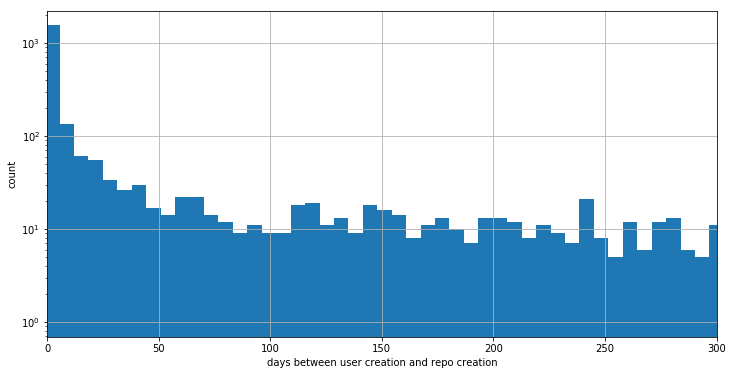

In [9]:
plt.figure(figsize=(12,6))
ages = user_repo['account_age_at_creation'].dropna().dt.days
ages[ages < 356].hist(bins=100)
plt.xlim(0,300)
plt.yscale('log')
plt.xlabel('days between user creation and repo creation')
plt.ylabel('count');